# Dataset Description

In this competition you will predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted. The data included text, tabular, and image data. See below for details.
This is a Kernels-only competition. At the end of the competition, test data will be replaced in their entirety with new data of approximately the same size, and your kernels will be rerun on the new data. 

## File descriptions


    * train.csv - Tabular/text data for the training set
    * test.csv - Tabular/text data for the test set
    * sample_submission.csv - A sample submission file in the correct format
    * breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
    * color_labels.csv - Contains ColorName for each ColorID
    * state_labels.csv - Contains StateName for each StateID


## Data Fields


    * PetID - Unique hash ID of pet profile
    * AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
    * Type - Type of animal (1 = Dog, 2 = Cat)
    * Name - Name of pet (Empty if not named)
    * Age - Age of pet when listed, in months
    * Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
    * Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
    * Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
    * Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
    * Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
    * Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
    * MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
    * FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
    * Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
    * Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
    * Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
    * Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
    * Quantity - Number of pets represented in profile
    * Fee - Adoption fee (0 = Free)
    * State - State location in Malaysia (Refer to StateLabels dictionary)
    * RescuerID - Unique hash ID of rescuer
    * VideoAmt - Total uploaded videos for this pet
    * PhotoAmt - Total uploaded photos for this pet
    * Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.


## AdoptionSpeed

Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way:
0 - Pet was adopted on the same day as it was listed.
1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

## Images

For pets that have photos, they will be named in the format of PetID-ImageNumber.jpg. Image 1 is the profile (default) photo set for the pet. For privacy purposes, faces, phone numbers and emails have been masked.

## Image Metadata

We have run the images through Google's Vision API, providing analysis on Face Annotation, Label Annotation, Text Annotation and Image Properties. You may optionally utilize this supplementary information for your image analysis.

File name format is PetID-ImageNumber.json.

Some properties will not exist in JSON file if not present, i.e. Face Annotation. Text Annotation has been simplified to just 1 entry of the entire text description (instead of the detailed JSON result broken down by individual characters and words). Phone numbers and emails are already anonymized in Text Annotation.

Google Vision API reference:
https://cloud.google.com/vision/docs/reference/rest/v1/images/annotate

## Sentiment Data

We have run each pet profile's description through Google's Natural Language API, providing analysis on sentiment and key entities. You may optionally utilize this supplementary information for your pet description analysis. There are some descriptions that the API could not analyze. As such, there are fewer sentiment files than there are rows in the dataset.

File name format is PetID.json.

Google Natural Language API reference:
https://cloud.google.com/natural-language/docs/basics

## Imports

In [3]:
import os
import json
from tqdm.notebook import tqdm
from glob import glob
from collections import defaultdict
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as rf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from concurrent.futures import ThreadPoolExecutor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import cohen_kappa_score
%matplotlib inline

## Get the Train Data

In [4]:
train = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/train/train.csv')
test = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/test/test.csv')

In [5]:
state_labels = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/state_labels.csv')

In [6]:
train['State'].head()

0    41326
1    41401
2    41326
3    41401
4    41326
Name: State, dtype: int64

In [7]:
state_labels.head()

,StateID,StateName
0,41336,Johor
1,41325,Kedah
2,41367,Kelantan
3,41401,Kuala Lumpur
4,41415,Labuan


In [8]:
train = train.merge(state_labels, left_on='State', right_on='StateID', how='left')
test = test.merge(state_labels, left_on='State', right_on='StateID', how='left')

In [9]:
train[['State', 'StateID', 'StateName']].head()

,State,StateID,StateName
0,41326,41326,Selangor
1,41401,41401,Kuala Lumpur
2,41326,41326,Selangor
3,41401,41401,Kuala Lumpur
4,41326,41326,Selangor


In [10]:
train.drop('StateID', axis=1, inplace=True)
test.drop('StateID', axis=1, inplace=True)

In [11]:
breed_labels = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/breed_labels.csv')

In [12]:
breed_labels.head()

,BreedID,Type,BreedName
0,1,1,Affenpinscher
1,2,1,Afghan Hound
2,3,1,Airedale Terrier
3,4,1,Akbash
4,5,1,Akita


In [13]:
train = train.merge(breed_labels, left_on='Breed1', right_on='BreedID', how='left')
test = test.merge(breed_labels, left_on='Breed1', right_on='BreedID', how='left')

In [14]:
train.columns

Index(['Type_x', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1',
       'Color2', 'Color3', 'MaturitySize', 'FurLength', 'Vaccinated',
       'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State',
       'RescuerID', 'VideoAmt', 'Description', 'PetID', 'PhotoAmt',
       'AdoptionSpeed', 'StateName', 'BreedID', 'Type_y', 'BreedName'],
      dtype='object')

In [15]:
train.drop(['Type_x', 'Type_y', 'BreedID'], axis=1, inplace=True)
test.drop(['Type_x', 'Type_y', 'BreedID'], axis=1, inplace=True)

In [16]:
color_id = pd.read_csv('/kaggle/input/petfinder-adoption-prediction/color_labels.csv')

In [17]:
color_id.head(10)

,ColorID,ColorName
0,1,Black
1,2,Brown
2,3,Golden
3,4,Yellow
4,5,Cream
5,6,Gray
6,7,White


In [18]:
train = train.merge(color_id, left_on='Color1', right_on='ColorID', how='left')
test = test.merge(color_id, left_on='Color1', right_on='ColorID', how='left')

In [19]:
train.drop('ColorID', axis=1, inplace=True)
test.drop('ColorID', axis=1, inplace=True)

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Name           13728 non-null  object 
 1   Age            14993 non-null  int64  
 2   Breed1         14993 non-null  int64  
 3   Breed2         14993 non-null  int64  
 4   Gender         14993 non-null  int64  
 5   Color1         14993 non-null  int64  
 6   Color2         14993 non-null  int64  
 7   Color3         14993 non-null  int64  
 8   MaturitySize   14993 non-null  int64  
 9   FurLength      14993 non-null  int64  
 10  Vaccinated     14993 non-null  int64  
 11  Dewormed       14993 non-null  int64  
 12  Sterilized     14993 non-null  int64  
 13  Health         14993 non-null  int64  
 14  Quantity       14993 non-null  int64  
 15  Fee            14993 non-null  int64  
 16  State          14993 non-null  int64  
 17  RescuerID      14993 non-null  object 
 18  VideoA

In [21]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Age,14993.0,10.452078,18.155790,0.0,2.0,3.0,12.0,255.0
Breed1,14993.0,265.272594,60.056818,0.0,265.0,266.0,307.0,307.0
Breed2,14993.0,74.009738,123.011575,0.0,0.0,0.0,179.0,307.0
Gender,14993.0,1.776162,0.681592,1.0,1.0,2.0,2.0,3.0
Color1,14993.0,2.234176,1.745225,1.0,1.0,2.0,3.0,7.0
Color2,14993.0,3.222837,2.742562,0.0,0.0,2.0,6.0,7.0
Color3,14993.0,1.882012,2.984086,0.0,0.0,0.0,5.0,7.0
MaturitySize,14993.0,1.862002,0.547959,1.0,2.0,2.0,2.0,4.0
FurLength,14993.0,1.467485,0.599070,1.0,1.0,1.0,2.0,3.0
Vaccinated,14993.0,1.731208,0.667649,1.0,1.0,2.0,2.0,3.0


In [22]:
train.isnull().sum()

Name             1265
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        13
PetID               0
PhotoAmt            0
AdoptionSpeed       0
StateName           0
BreedName           5
ColorName           0
dtype: int64

In [23]:
train.duplicated().sum()

0

## EDA

In [24]:
train['Name'].fillna('Unnamed', inplace=True)
test['Name'].fillna('Unnamed', inplace=True)

In [25]:
train['Description'].fillna('No Description', inplace=True)
test['Description'].fillna('No Description', inplace=True)

In [26]:
train['Description_length'] = train['Description'].str.len()
test['Description_length'] = test['Description'].str.len()

In [27]:
train.dropna(subset=['BreedName'], inplace=True)
test.dropna(subset=['BreedName'], inplace=True)

<Axes: >

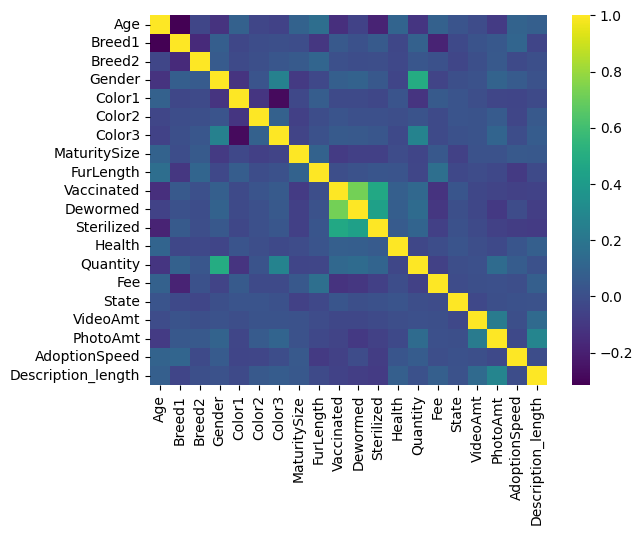

In [28]:
sns.heatmap(train.corr(numeric_only=True), cmap='viridis')

Text(0.5, 1.0, 'Histogram of Adoption Speed')

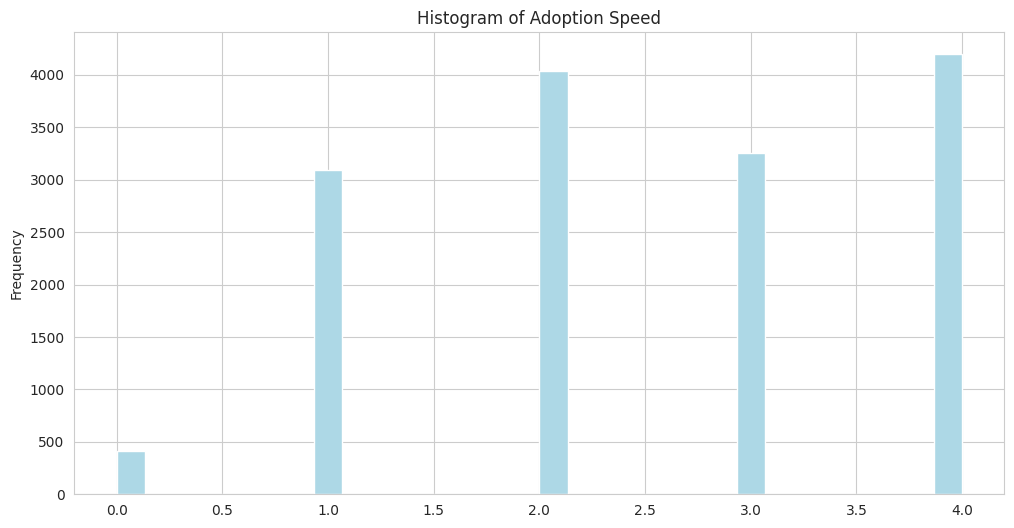

In [29]:
sns.set_style('whitegrid')
plt.figure(figsize=(12,6))
train['AdoptionSpeed'].plot(kind='hist', bins=30, color = 'lightblue')
plt.title('Histogram of Adoption Speed')

Text(0.5, 1.0, 'Histogram of Age of the Pets')

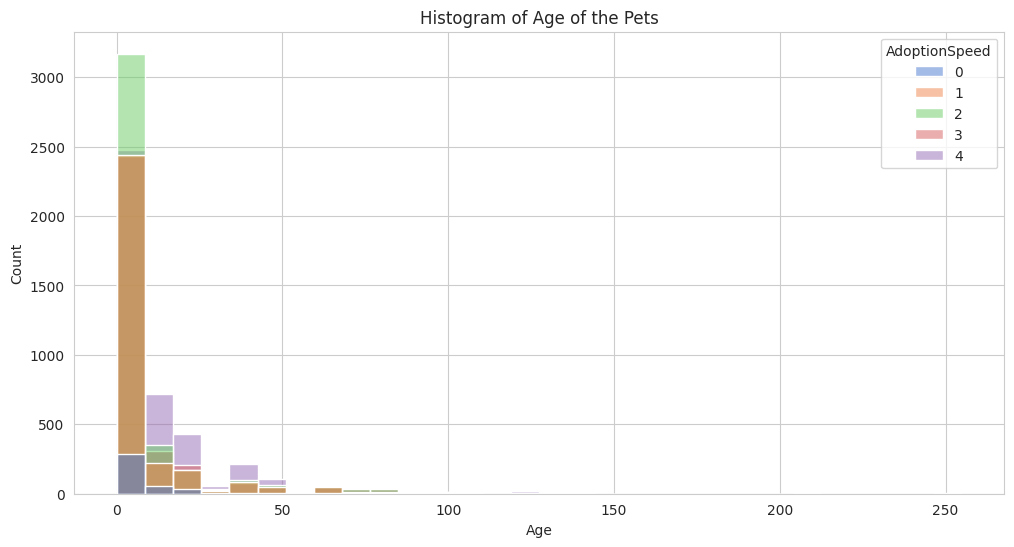

In [30]:
plt.figure(figsize=(12,6))
sns.histplot(data=train, x='Age', hue='AdoptionSpeed', bins=30, palette='muted')
plt.title('Histogram of Age of the Pets')

Text(0.5, 1.0, 'Number of Adopted Pets based off Health Conditions')

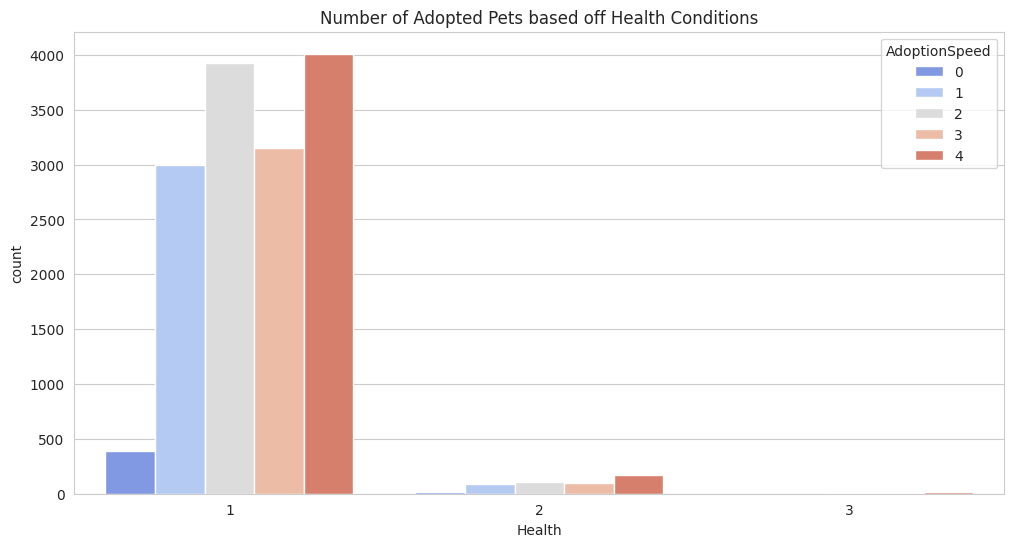

In [31]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x='Health', hue='AdoptionSpeed', palette='coolwarm')
plt.title('Number of Adopted Pets based off Health Conditions')

Text(0.5, 1.0, 'Number of Adopted Pets based off Vaccination')

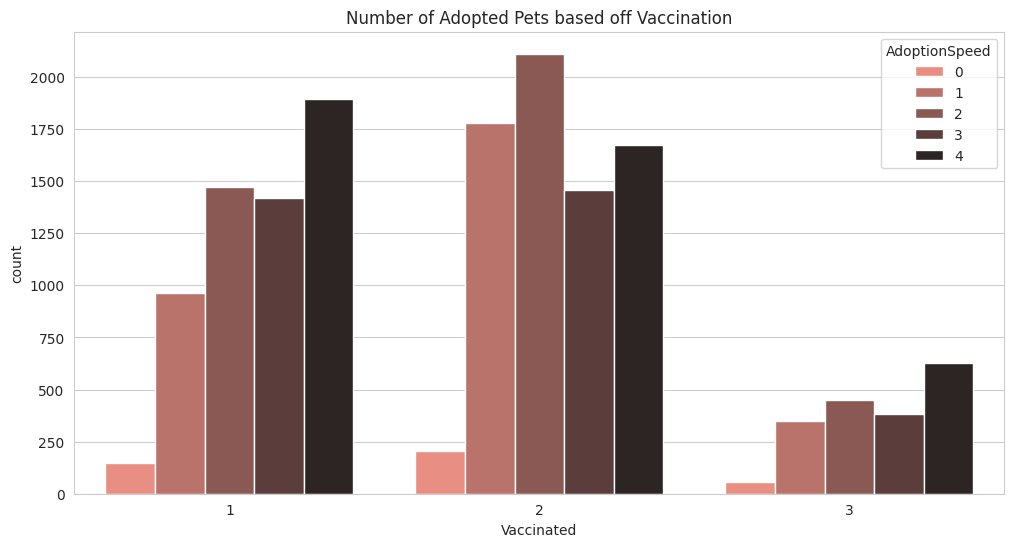

In [32]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x='Vaccinated', hue='AdoptionSpeed', palette='dark:salmon_r')
plt.title('Number of Adopted Pets based off Vaccination')

Text(0.5, 1.0, 'Number of Adopted Pets based off Gender')

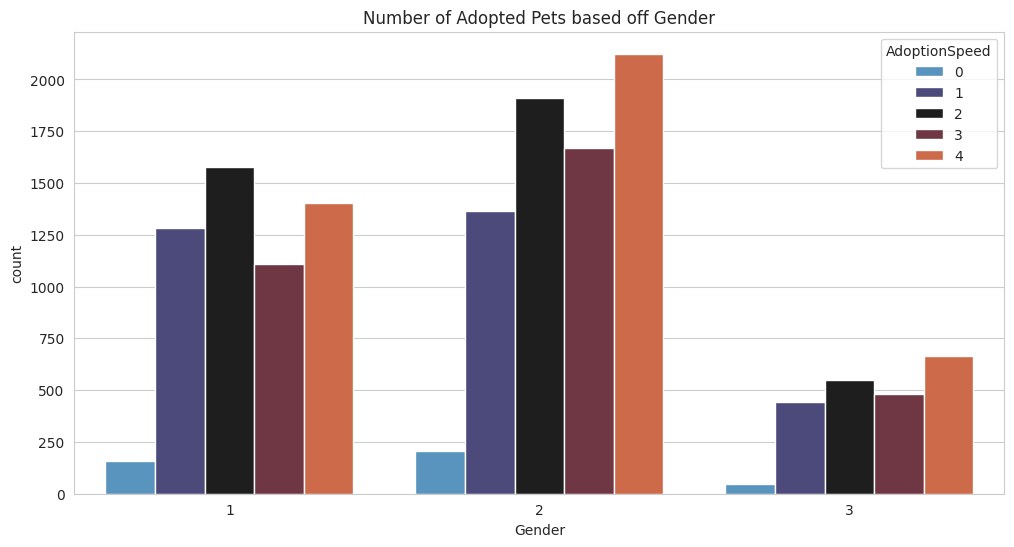

In [33]:
plt.figure(figsize=(12,6))
sns.countplot(data=train, x='Gender', hue='AdoptionSpeed', palette='icefire')
plt.title('Number of Adopted Pets based off Gender')

Text(0.5, 1.0, 'PhotoAmt Distribution by AdoptionSpeed')

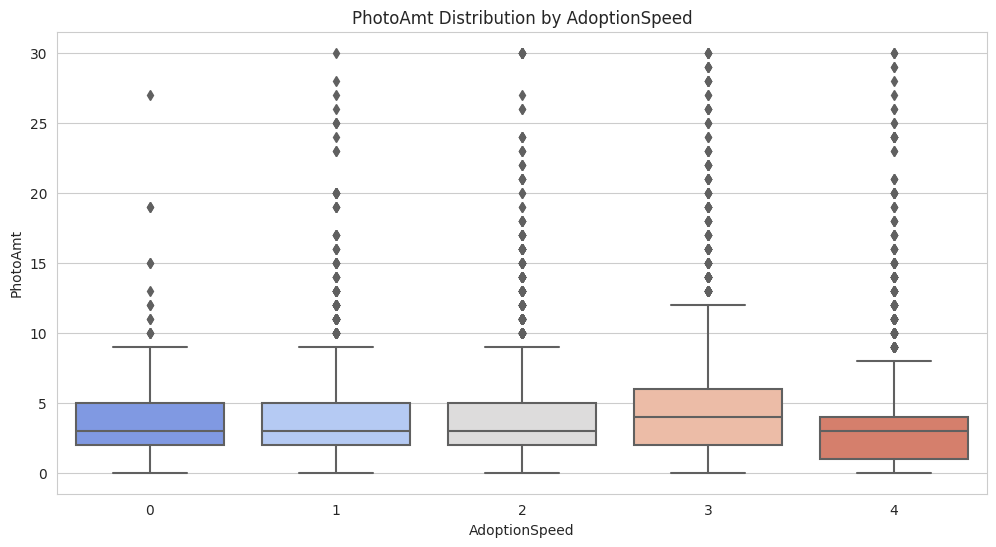

In [34]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='AdoptionSpeed', y='PhotoAmt', data=train, palette='coolwarm')
plt.title('PhotoAmt Distribution by AdoptionSpeed')

In [35]:
train[['Description_length', 'AdoptionSpeed']].corr()

,Description_length,AdoptionSpeed
Description_length,1.000000,-0.010067
AdoptionSpeed,-0.010067,1.000000


In [36]:
train.drop('Description_length', axis=1, inplace=True)
test.drop('Description_length', axis=1, inplace=True)

In [37]:
train['Name_length'] = train['Name'].str.len()
test['Name_length'] = test['Name'].str.len()

In [38]:
train[['Name_length', 'AdoptionSpeed']].corr()

,Name_length,AdoptionSpeed
Name_length,1.000000,-0.003262
AdoptionSpeed,-0.003262,1.000000


In [39]:
train.drop('Name_length', axis=1, inplace=True)
test.drop('Name_length', axis=1, inplace=True)

In [40]:
train['Mixed_Breed'] = (train['Breed1'] != train['Breed2']).astype(int)
test['Mixed_Breed'] = (test['Breed1'] != test['Breed2']).astype(int)

In [41]:
train['Mixed_Breed'].value_counts()

Mixed_Breed
1    13478
0     1510
Name: count, dtype: int64

In [42]:
train['ColorCombo'] = train[['Color1', 'Color2', 'Color3']].astype(str).apply('_'.join, axis=1)
test['ColorCombo'] = test[['Color1', 'Color2', 'Color3']].astype(str).apply('_'.join, axis=1)

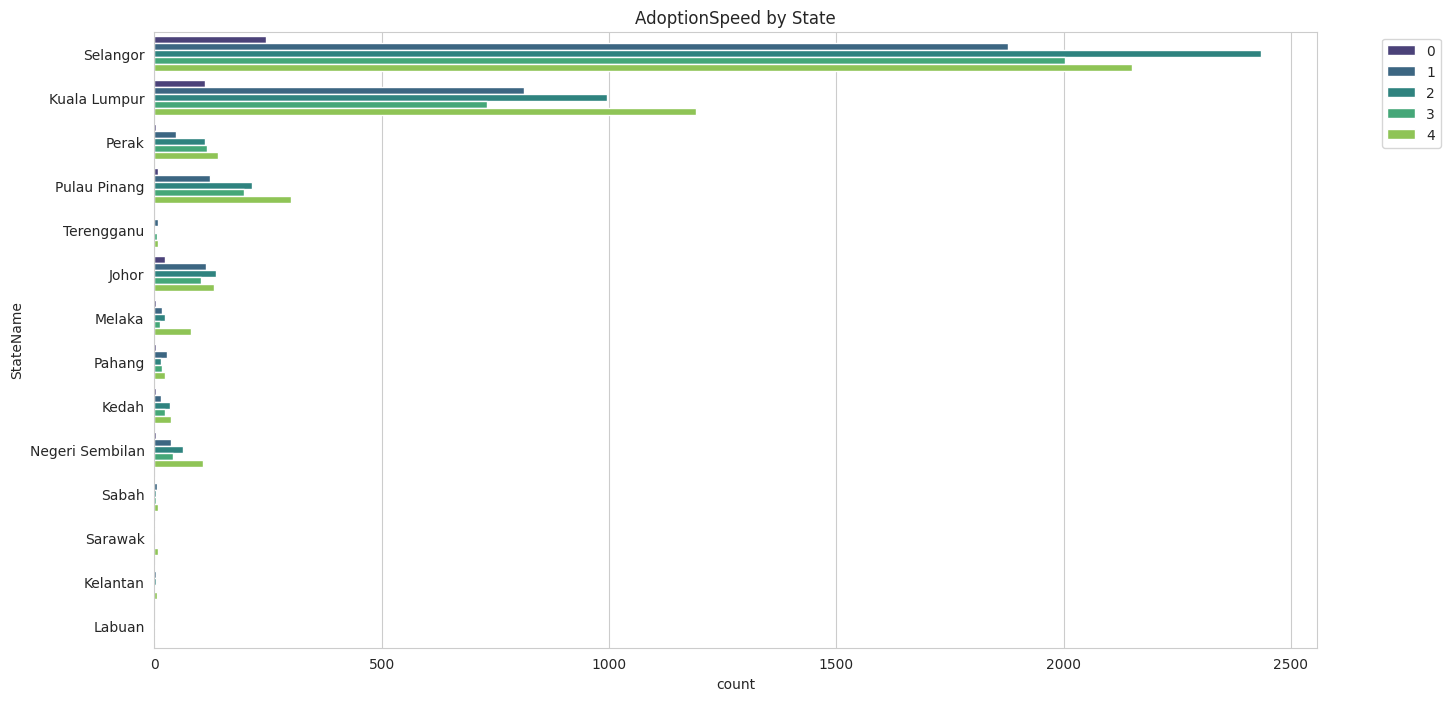

In [43]:
plt.figure(figsize=(15, 8))
sns.countplot(y='StateName', hue='AdoptionSpeed', data=train, palette='viridis')
plt.title('AdoptionSpeed by State')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

## Bringing the Images into Play

In [44]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

2025-07-25 17:27:45.058016: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [45]:
def extract_features(image_path):
    if pd.isna(image_path) or image_path is None:
        return np.zeros(2048)
    try:
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x, verbose=0).flatten()
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return np.zeroes(2048)

In [46]:
def find_image_path(pet_id, folder):
    matches = glob(os.path.join(folder, f"{pet_id}-*.jpg"))
    if matches:
        return matches[0]
    else:
        return None

In [47]:
def build_image_dict(folder):
    image_dict = defaultdict(list)
    for f in Path(folder).glob("*-*.jpg"):
        pet_id = f.name.split('-')[0]
        image_dict[pet_id].append(str(f))
    return image_dict

In [48]:
train_dict = build_image_dict('/kaggle/input/petfinder-adoption-prediction/train_images')
train['image_path'] = train['PetID'].map(lambda x: train_dict.get(x, [None])[0])

In [49]:
test_dict = build_image_dict('/kaggle/input/petfinder-adoption-prediction/test_images')
test['image_path'] = test['PetID'].map(lambda x: test_dict.get(x, [None])[0])

In [50]:
image_features_train = np.array([extract_features(path) for path in train['image_path']])

In [51]:
image_features_test = np.array([extract_features(path) for path in test['image_path']])

## Involving Metadata

In [52]:
def load_metadata(pet_id, metadata_folder):
    metadata = []
    json_files = glob(os.path.join(metdata_folder, f"{pet_id}-*.json"))
    for file in json_files:
        with open(file, 'r') as f:
            metadata.append(json.load(F))
    return metadata

In [53]:
def process_file(file):
    try:
        pet_id = Path(file).name.split('-')[0]
        with open(file, 'r', encoding='utf-8') as f:
            return pet_id, json.load(f)
    except Exception as e:
        print(f"Error processing {file}: {str(e)}")
        return None

In [54]:
def build_metadata_dict(metadata_folder):
    metadata_dict = defaultdict(list)
    files = list(Path(metadata_folder).glob("*-*.json"))
    
    print(f"Found {len(files)} JSON files to process...")
    
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(tqdm(
            executor.map(process_file, files),
            total=len(files),
            desc="Processing JSONs"
        ))
    
    for result in results:
        if result:  # Skip failed files
            pet_id, data = result
            metadata_dict[pet_id].append(data)
    
    print(f"Processed {len(metadata_dict)} unique pets")
    return metadata_dict

In [55]:
train_metadata_dict = build_metadata_dict("/kaggle/input/petfinder-adoption-prediction/train_metadata")
test_metadata_dict = build_metadata_dict("/kaggle/input/petfinder-adoption-prediction/test_metadata")

Found 58311 JSON files to process...


Processing JSONs:   0%|          | 0/58311 [00:00<?, ?it/s]

Processed 14652 unique pets
Found 14465 JSON files to process...


Processing JSONs:   0%|          | 0/14465 [00:00<?, ?it/s]

Processed 3858 unique pets


In [56]:
def extract_animal_info(entries):
    animal_data = []
    for entry in entries:
        for annotation in entry.get('labelAnnotations', []):
            # Case-insensitive check for more animal types
            if annotation['description'].lower() in ['cat', 'dog', 'kitten', 'puppy', 'feline', 'canine']:
                animal_data.append({
                    'detected_animal': annotation['description'],
                    'animal_confidence': annotation['score']
                })
    return animal_data if animal_data else [{'detected_animal': 'unknown', 'animal_confidence': 0}]

def extract_dominant_colors(entries):
    color_info = []
    for entry in entries:
        colors = entry.get('imagePropertiesAnnotation', {}).get('dominantColors', {}).get('colors', [])
        for color in colors[:3]:  # Top 3 colors
            color_info.append({
                'red': color['color'].get('red', 0),
                'green': color['color'].get('green', 0),
                'blue': color['color'].get('blue', 0),
                'color_score': color['score']
            })
    # Return default gray if no colors found
    return color_info if color_info else [{'red': 128, 'green': 128, 'blue': 128, 'color_score': 0}]


def extract_crop_quality(entries):
    crop_scores = []
    for entry in entries:
        crops = entry.get('cropHintsAnnotation', {}).get('cropHints', [])
        if crops:
            crop_scores.append(crops[0].get('confidence', 0))
    return sum(crop_scores)/len(crop_scores) if crop_scores else 0

def extract_all_metadata_features(metadata_dict):
    features = {}
    for pet_id, entries in metadata_dict.items():
        # Skip if no entries exist for this pet
        if not entries:
            features[pet_id] = {
                'primary_animal': 'unknown',
                'avg_animal_confidence': 0,
                'dominant_red': 128,
                'dominant_green': 128,
                'dominant_blue': 128,
                'crop_confidence': 0,
                'num_labels': 0
            }
            continue
            
        try:
            animal_info = extract_animal_info(entries)
            color_info = extract_dominant_colors(entries)
            
            features[pet_id] = {
                # Animal detection
                'primary_animal': animal_info[0]['detected_animal'],
                'avg_animal_confidence': np.nanmean([a['animal_confidence'] for a in animal_info]),
                
                # Color analysis
                'dominant_red': color_info[0]['red'],
                'dominant_green': color_info[0]['green'],
                'dominant_blue': color_info[0]['blue'],
                'avg_color_score': np.nanmean([c['color_score'] for c in color_info]),
                
                # Image quality
                'crop_confidence': extract_crop_quality(entries),
                
                # Additional metrics (safe division)
                'num_labels': sum(len(e.get('labelAnnotations', [])) for e in entries)/max(1, len(entries))
            }
        except Exception as e:
            print(f"Error processing {pet_id}: {str(e)}")
            features[pet_id] = {
                'primary_animal': 'error',
                'avg_animal_confidence': 0,
                'dominant_red': 128,
                'dominant_green': 128,
                'dominant_blue': 128,
                'avg_color_score': 0,
                'crop_confidence': 0,
                'num_labels': 0
            }
    
    return pd.DataFrame.from_dict(features, orient='index').fillna(0)

In [57]:
metadata_features_train = extract_all_metadata_features(train_metadata_dict)

In [58]:
metadata_features_test = extract_all_metadata_features(test_metadata_dict)

In [59]:
image_features_df = pd.DataFrame(image_features_train, index=train['PetID'], columns=[f'img_{i}' for i in range(image_features_train.shape[1])])

In [60]:
image_features_df_test = pd.DataFrame(image_features_test, index=test['PetID'], columns=[f'img_{i}' for i in range(image_features_test.shape[1])])

In [61]:
metadata_features_train = metadata_features_train.reset_index().rename(columns={'index':'PetID'})

In [62]:
metadata_features_test = metadata_features_test.reset_index().rename(columns={'index':'PetID'})

In [63]:
df_train = (train.merge(metadata_features_train, on='PetID', how='left').merge(image_features_df, left_on='PetID', right_index=True, how='left'))

In [64]:
df_test = (test.merge(metadata_features_test, on='PetID', how='left').merge(image_features_df_test, left_on='PetID', right_index=True, how='left'))

## Train Test Split

In [65]:
X = df_train.drop(['RescuerID', 'image_path', 'Description', 'StateName', 'BreedName', 'ColorName',
                   'AdoptionSpeed', 'Name', 'PetID', 'ColorCombo', 'primary_animal', 'Mixed_Breed'],
                  axis=1)
y = df_train['AdoptionSpeed']

# Drop rows where X has NaN and ensure y aligns
nan_mask = X.isnull().any(axis=1)
X_clean = X[~nan_mask]
y_clean = y[~nan_mask]  

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.25, random_state=42)

## Training a XGBosst Model

In [2]:
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

print(confusion_matrix(y_test,xgb_predictions))
print('\n')
print(classification_report(y_test,xgb_predictions))

NameError: name 'XGBClassifier' is not defined

## Training a Random Forest Model

In [67]:
rf_model = RandomForestClassifier(n_estimators=100)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

print(confusion_matrix(y_test,rf_predictions))
print('\n')
print(classification_report(y_test,rf_predictions))

[[  0  20  45   6  28]
 [  0 171 328  56 177]
 [  0 154 468 102 309]
 [  0  97 307 106 273]
 [  0  97 285  95 538]]


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.32      0.23      0.27       732
           2       0.33      0.45      0.38      1033
           3       0.29      0.14      0.18       783
           4       0.41      0.53      0.46      1015

    accuracy                           0.35      3662
   macro avg       0.27      0.27      0.26      3662
weighted avg       0.33      0.35      0.33      3662



## Training a NN Model

Epoch 1/600
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1904 - loss: 2.0185 - val_accuracy: 0.2589 - val_loss: 1.5535
Epoch 2/600
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2349 - loss: 1.7274 - val_accuracy: 0.2785 - val_loss: 1.5281
Epoch 3/600
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2600 - loss: 1.5996 - val_accuracy: 0.3094 - val_loss: 1.4982
Epoch 4/600
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2676 - loss: 1.5569 - val_accuracy: 0.3195 - val_loss: 1.4720
Epoch 5/600
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2928 - loss: 1.5055 - val_accuracy: 0.3342 - val_loss: 1.4526
Epoch 6/600
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3056 - loss: 1.4797 - val_accuracy: 0.3367 - val_loss: 1.4406
Epoch 7/600
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3055 - loss: 1.4662 - val_accuracy: 0.3408 - val_loss: 1.4356
Epoch 8/600
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3094 - loss: 1.4539 - val_accuracy: 0.

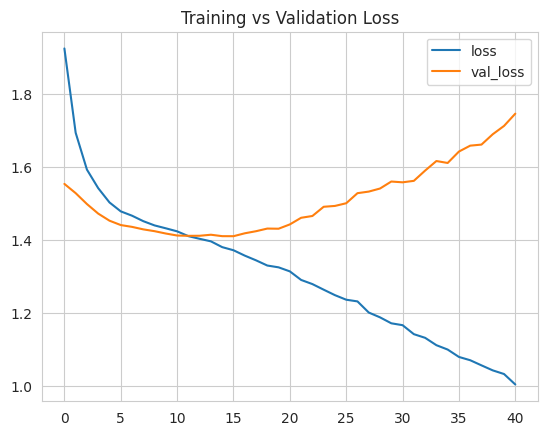

In [68]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()

# input layer
model.add(Dense(128, activation='relu', input_shape = (2073,)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# first hidden layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# second hidden layer
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# third hidden layer
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# fourth hidden layer
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# output layer 
model.add(Dense(units=5, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25, restore_best_weights=True)

model.fit(x=X_train_scaled, y=y_train, batch_size=128, epochs=600, validation_data=[X_test_scaled,y_test], callbacks=[early_stop])

loss_nn = pd.DataFrame(model.history.history)
loss_nn[['loss', 'val_loss']].plot()
plt.title('Training vs Validation Loss')
plt.show()

## Sumbission

In [69]:
ids = df_test['PetID']
X_test_kaggle = df_test.drop(['RescuerID', 'image_path', 'Description', 'StateName', 'BreedName', 'ColorName'
                                , 'Name', 'PetID', 'ColorCombo', 'primary_animal', 'Mixed_Breed'],
                  axis=1)
nan_mask_test = X_test_kaggle.isnull().any(axis=1)
X_test_kaggle = X_test_kaggle[~nan_mask_test]
ids = ids[~nan_mask_test]

In [70]:
ids.shape

(3858,)

In [ ]:
rf_prediction_kaggle = rf_model.predict(X_test_kaggle)

# submission Random Forest
submission_rf = pd.DataFrame({'PetID': ids, 'AdoptionSpeed':rf_prediction_kaggle})
submission_rf.to_csv('submission_rf.csv', index = False)

In [1]:
xgb_prediction_kaggle = xgb_model.predict(X_test_kaggle)

# submission XGBoost
submission_xgb = pd.DataFrame({'PetID': ids, 'AdoptionSpeed':xgb_prediction_kaggle})
submission_xgb.to_csv('submission.csv', index = False)

NameError: name 'xgb_model' is not defined

In [ ]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

X_test_kaggle_scaled = scaler.transform(X_test_kaggle)
nn_prediction_kaggle_scaled = model.predict(X_test_kaggle_scaled)
nn_prediction_kaggle = np.argmax(nn_prediction_kaggle_scaled, axis=1)

# submission NN
submission_nn = pd.DataFrame({'PetID': ids, 'AdoptionSpeed':nn_prediction_kaggle.reshape(-1)})
submission_nn.to_csv('submission_nn.csv', index = False)